[View in Colaboratory](https://colab.research.google.com/github/sungreong/Bayseian_elementary_R/blob/master/MCMC_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.ipynb)

## Markov Chain Monte Carlo sampling 

$ P(\theta | x ) =  \frac{P(x | \theta )P(\theta)}{P(x)} $

Stationary distribution 의 조건인 ergodic , reversible, irreducible을 만족한다면 사용가능하다 [참고](https://medium.com/@kim_hjun/markov-chain-stationary-distribution-5198941234f6)

[참고2](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)

mcmc를 이용해서 사후분포를 추론 할 수 있게 되는데. 기존의 메트포롤리스 알고리즘에서 정치인 문제로써,  
섬이 7개의 discrete uniform 형태의 추정에서 continuous한 분포에 대한 추정으로 확장이라고 할 수 있다.

분포 추정을 할 때 $ P(x) $ 라는 부분이 Propostional 한 분포와  current 분포에 둘 다 존재 하므로 가볍게 약분이 된다  
$ \frac{ P_{pro}(x | \theta )P_{pro}(\theta)}{P_{cur}(x | \theta )P_{cur}(\theta)} $  의 형태로 바뀌게 되면서   
$ P(x) = \int P(x | \theta )P(\theta) d_{\theta} $ 인데 이 형태는 실제로 우리가 알지 못하는 분포일수도 있고 까다롭게 계산이 될수 있는 부분인데, 하지만 이 부분은 우리가 지금 알고 싶은 $ \theta $ 에는 관련이 없는  constant 같은 부분이기 때문에 크게 신경을 써도 되지 않는 부분으로 바뀌게 된다. 이제 그래서 메트로 폴리스 알고리즘에 베이지안 추론 방법을 이용하여 사후확률 분포를 그릴 수 있다.


In [0]:
%matplotlib inline 

import numpy as np
import scipy as sp
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import invgamma
from scipy.stats import t
sns.set_style("white")
sns.set_context("talk")

np.random.seed(123)

$ N(0,1) $ 라는 분포에서 20개 정도 sampling 을 하겠다.  
우리는 이 것을 통해 사후 분포의 평균을 추정할 것이다. 

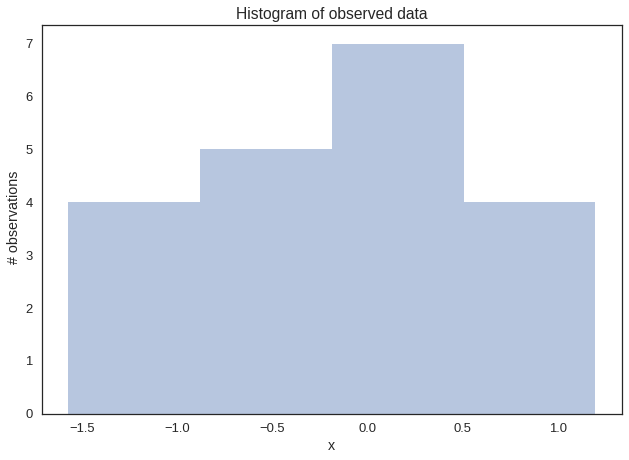

In [2]:
data = np.random.randn(20)
ax = plt.subplot()
sns.distplot(data , kde=False , ax=ax)
_ = ax.set(title="Histogram of observed data" , xlabel ="x", ylabel =" # observations")

이제 모델을 지정을 할 것이다. 우리의 가정은 일단 Normal 분포에서 데이터를 가져왔다.  
가능도 함수 역시 Normal로 생각한다.  공액사전분포표와 증명을 보면 알 수 있듯이 만약 우리가
Normal 분포가 Prior 이고 Normal 분포가 Likelihood 라면 Posterior 역시 Normal 이 된다는 것을 알고 있다.
표준 편차도 1이라고 일단 가정을 하겠다. 

$ \mu \sim Normal(0, 1) \\
 x|\mu \sim Normal(x ; \mu, 1) $
[위키_공액사전분포표](https://en.wikipedia.org/wiki/Conjugate_prior)  
[Normal 증명](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM)

밑에의 경우는 분산을 알고 있을 때 $\mu$ 를 추정하는 것이다.

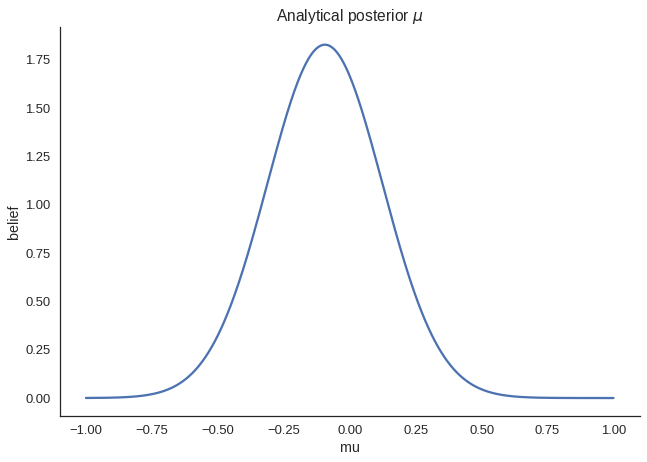

In [9]:
# sigma known
def calculation_post_mu(data, x, mu_0 , sigma_0) :
    sigma= 1.
    n= len(data)
    mu_post = (mu_0 / sigma**2 + data.sum() / sigma**2)  / (1./sigma_0**2 +n / sigma**2)
    sigma_post = (1. /sigma_0**2 + n/ sigma**2 )**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax =plt.subplot()
x= np.linspace(-1, 1, 500)
post_analytical = calculation_post_mu(data, x, 0. ,1.)
ax.plot(x, post_analytical)
ax.set(xlabel="mu", ylabel="belief", title="Analytical posterior $\mu$")
sns.despine()

밑에의 경우는 mu를 알고 있을 때 

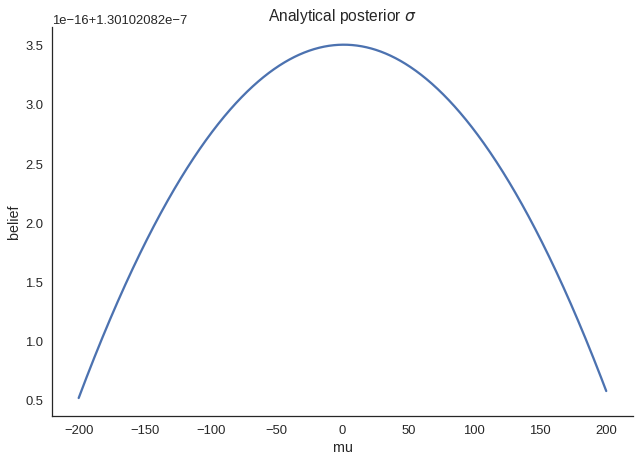

In [25]:
def calculation_post_sigma(data, x, alpha_0 , beta_0) :
    mu= 1.
    n= len(data)
    mu_post = alpha_0 + n/2 
    sigma_post = beta_0 + np.sum((x-mu)**2) /2
    return t(df=2*mu_post,loc=mu, scale= sigma_post/mu_post).pdf(x)

ax =plt.subplot()
x= np.linspace(-200,200, 5000)
alpha_0, beta_0 = 1,1
post_analytical = calculation_post_sigma(data, x, alpha_0 , beta_0)
ax.plot(x, post_analytical)
ax.set(xlabel="mu", ylabel="belief", title="Analytical posterior $\sigma$")
sns.despine()

# 하지만 단점이 존재 한다.
data가 보여진 것을 이용해 $ \mu$ 값을 추정 할 수 있었다. 
그러나 만약 공액사전분포가 아니라면 이렇게 풀 수 는 없을 겄이다.

# MCMC 코드 설명하기

 1.  일단 처음 시작할 부분을 찾아야한다.그래서 임의적으로 고정을 시킨다
```
현재 위치 = 1
```
 2. 그 다음 우리는 다른 위치로 이동할 것을 제안한다. 이때 어떻게 제안을 제시할지에 대해서 매우 신중해야한다.
 3. Metropolis sampler 는 멍청하다 그래서 관계가 없는 샘플을 뽑을 수도 있다.dlfeks
```
제안 = norm( 평균(현재위치), 분산(제안의 넓이)).rvs()
```
 4. 다음으로 너는 그 다음 곳이 좋지 않드 나쁘든 간에 평가를 해야한다. 만약 결과값이 이전 위치보다 더 좋게 나온다면 우리는 그 곳을 현재 위치로 지정을 하면 된다.   
**그렇다면 더 좋게 나온다는 의미가 무엇이냐?** 제안 된 매개 변수 값으로 우도 (normal)가 주어지면 데이터의 확률을 계산하여 적합도를 정량화할 수 있다. (제안 평균 0  편차 1)   
 이 것은 쉽게 scipy.stats.normal(mu, sigma).pdf(data)  을 사용하여 개개인의 확률 값을 곱함으로써 데이터의 확률을 계산 할 수 있다.  
 i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

```
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal
```

# $ \frac{ P_{pro}(x | \theta )P_{pro}(\theta)}{P_{cur}(x | \theta )P_{cur}(\theta)} $ 와 같은 식이 된다.

 
  *   지금까지는 단지 랜덤 위치안에서 움직임을 제안하고 그리고 만약 mu_proposal 이  mu_current 보다 높다면  받아 들여지는 hill-climbing algorithm 사용 했다.
  * 결국 우리는 더이상 움직이지 않을 때까지 움직여서 mu=0이 얻을 것이다. 
  * 그러나 다른 위치안에서 움직임을 받아 들여지는 때때로 확인해 봐야 한다. 이러한 트릭으로 두 확률 분포를 나눠주는 것이다.
  
```
p_accept = p_proposal / p_current
```

* p_proposal이 더 크다면 이 값은 1이 넘어서 항상 1보다 크므로 제안된 곳으로 가지만 만약 p_current 가 더 크게 되면 확률값을 판단해서 움직임을 정하게 된다.

```
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal
```
# $\frac{ \frac{P_{pro}(x|μ)P_{pro}(μ)}{P(x)} }{  \frac{P_{cur}(x|μ)P_{cur}(μ)}{P(x)} }  =   \frac{P_{pro}(x|μ)P_{pro}(μ)}{P_{cur}(x|μ)P_{cur}(μ)}$

## 왜 이것을 이해해야하냐면?

다시 말하자면 제안된 모수의 사후확률을 현재의 사후확률로 나눠주게 설정함으로써, $p(x) 는 우리가 계산할 수 없는 수치 $ 를 약분해서 제거 할 수 있게 된다.  그래서 우리는 단지 통으로 제안된 사후확률분포에서 현재의 사후확률분포를 나눠줘도 되는 것이다. 
* 이것을 통해 우리는 상대적으로 적은 사후확률분포의 확률 값보다 더 높은 사후확률분포 값에 더 많이 움직이게 된다.

In [0]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior
        


# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calculation_post_mu(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calculation_post_mu(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calculation_post_mu(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()
    

# MCMC 시각화

##1 열
* prior 분포이다.  $ \mu $ 에 대한 우리의 믿음의 정도는 데이터를 보기 전이다. 
* 우리의 $ \mu $ 제안들에 연결하고 분포가 안정적인지 볼 수 있다. 
* vertical lines는 우리의 현재 $ \mu $ (파랑색) 과 $ \mu $ (초록색 또는 빨간색) 기각 여부에 따라 나오는 것을 확인 할 수 있다.

##2 열
* 가능도 함수에 관한 이야기인데, 우리의 모델이 데이터를 잘 설명하는지 평가하는데 사용할 수 있다. 
* $ \mu $ 에 제안된 것에 따라 가능도 함수는 변경하는 것을 볼 수 있다.
* Blue histogram 이 우리의 데이터이다.  solid line(초록색 or 빨간색)은 현재 제안된 $ \mu $ 의 가능도 함수이다.
* 직관적으로 가능도 함수와 데이터 사이에 중복이 있다. 같은 색깔의 dotted line 은 제안된 $ \mu $ 이고 파란색 dotted line은 현재 $ \mu $ 이다.

##3 열
* 사후분포이다 여기서 우리는 위에서 찾은 정규화된 사후값을 알 수 있다. 
*우리는 단지 현재와 제안된 $ \mu $  사전분포와 그것에 대한 $ \mu $ 가능도 함수의 곱을 이용해서 그 나눈 비율을 이용해 기각확률을  얻는다.

##4 열
* 흔적을 추적하는 행위다 (즉 우리가 생성한 $ \mu $ 에 대한 사후 샘플이다.)
* 각각의 샘플 기각 여부와 상관 없이 각각의 샘플을 저장 할 수 있다.

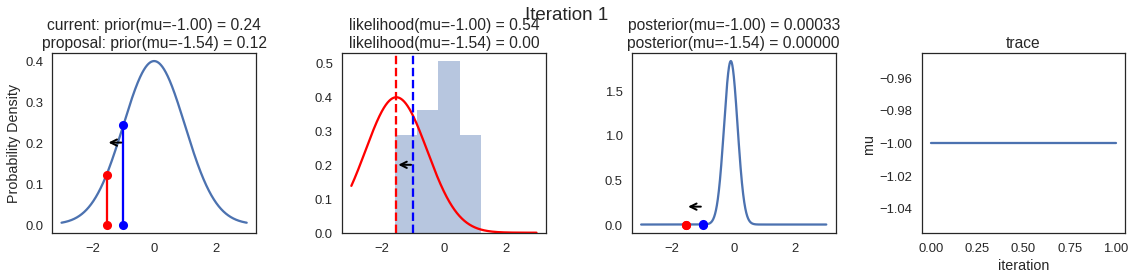

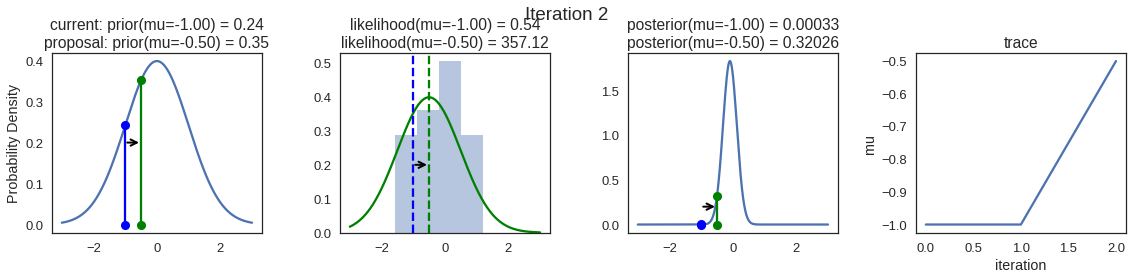

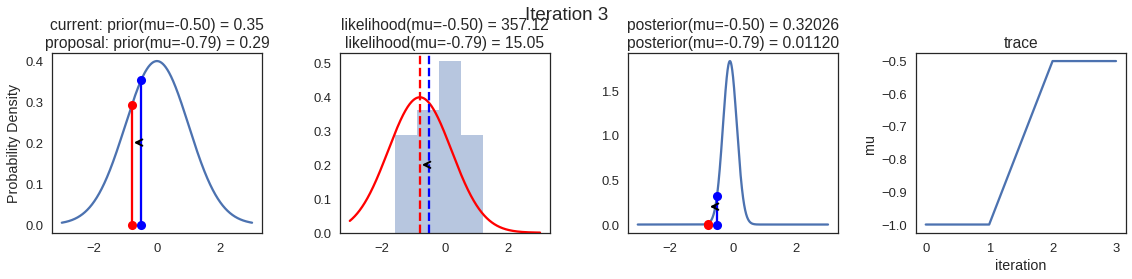

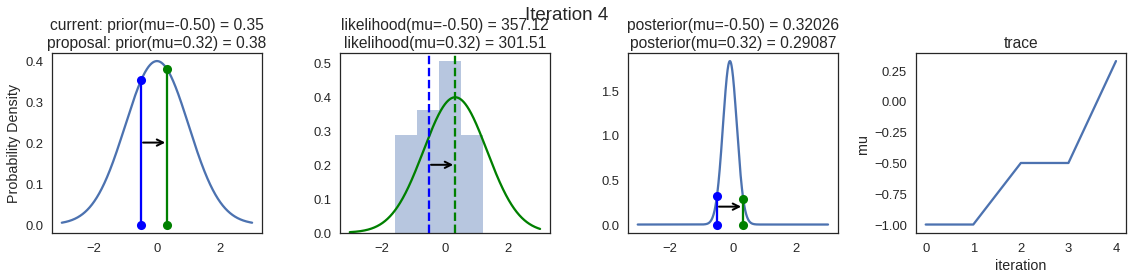

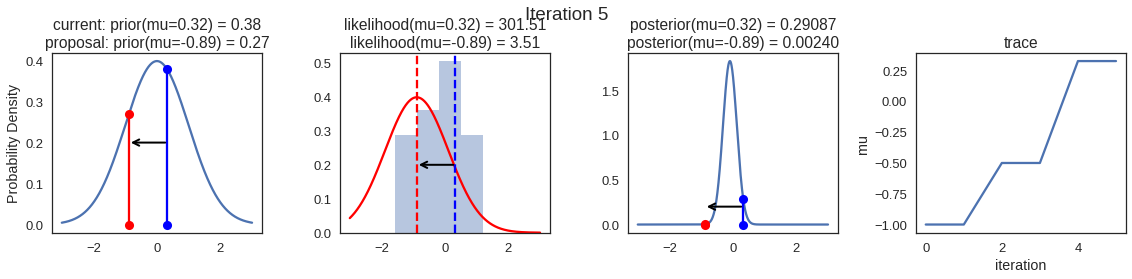

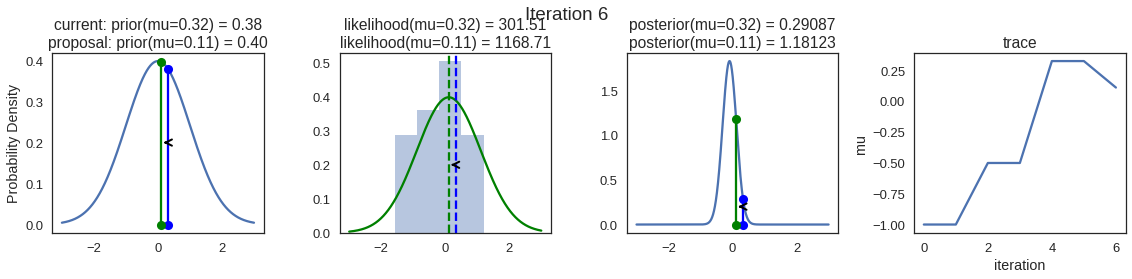

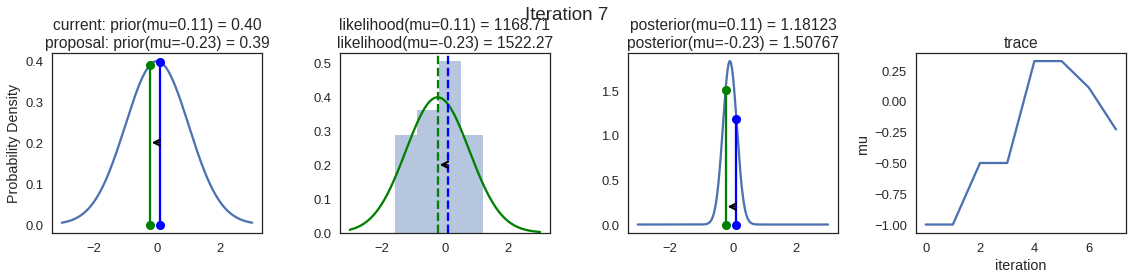

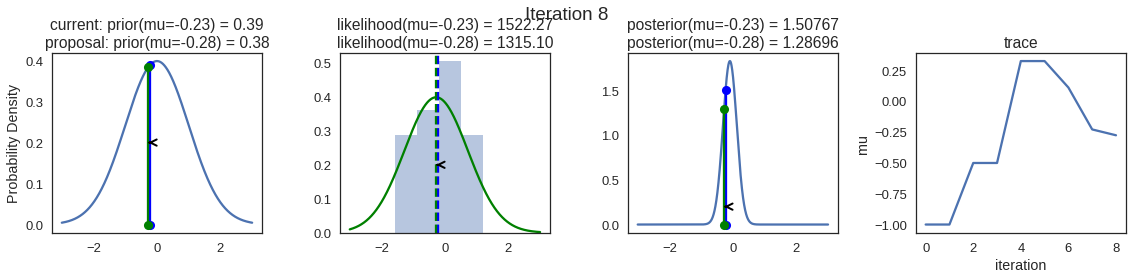

In [37]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

모델로 만든 사후 분포의 샘플로부터 우리는 값을 얻을 수 있다. 

In [0]:
posterior = sampler(data, samples=15000, mu_init=1.)


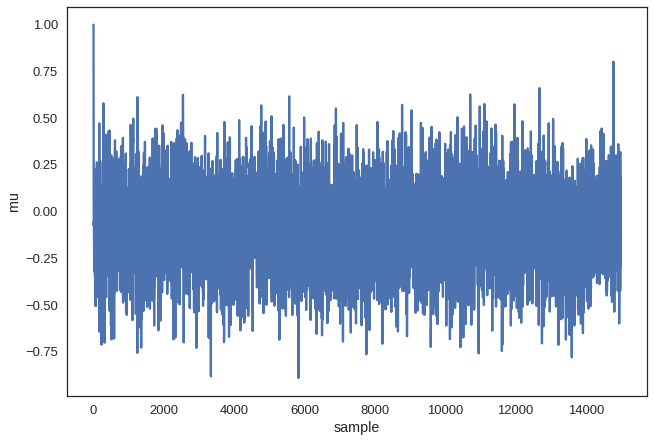

In [46]:
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

이 과정을 지금 trace 라고 한다.  사후 값의 근사를 얻기 위해 우리는 이 것을 이용해 히스토그램을 그릴 수 있다.
* 겉보기에는 모델 위에서 적합시킨 데이터와 유사할 지라도 두가지가 구별되어 있다. 이것은 중요하다
* $ \mu $에 대한 우리의 믿음은 아래의 plot에서 확인 할 수 있다.
* 이것은 사전분포와 가능도 함수의 분포와는 전혀 다른 분포가 생성 된다.

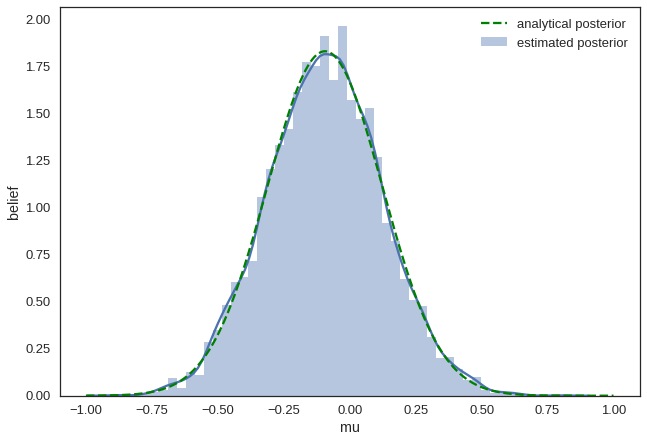

In [49]:
ax = plt.subplot()
sns.distplot(posterior[500:] ,ax= ax, label="estimated posterior")
x = np.linspace(-1,1, 500)
post = calculation_post_mu(data, x, 0, 1)
ax.plot(x, post,"g--", label="analytical posterior")
_ = ax.set(xlabel="mu", ylabel="belief")
ax.legend()

## Proposal Width
간격(편차) 0.5로 설정했다.  이것은 꽤 잘된 것을 확인 했고 일반적으로 너무 좁게하면 안된다.  
**왜냐하면 샘플링이 전체 파리미터를 탐사하는데 좁은 곳을 하다보니 비효율적으로 움직일 수 있고, 그리고 random-walk 형태를 띄게 되기 때문이다. **

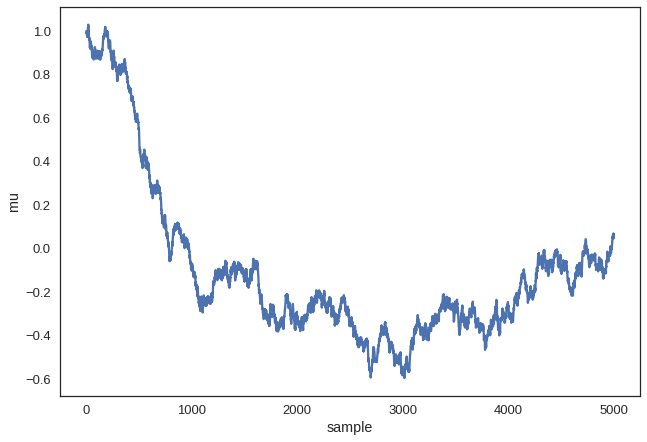

In [50]:
# width = 0.1 => 0.01
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

그렇다고 또 너무 넓게 해서도 안된다.

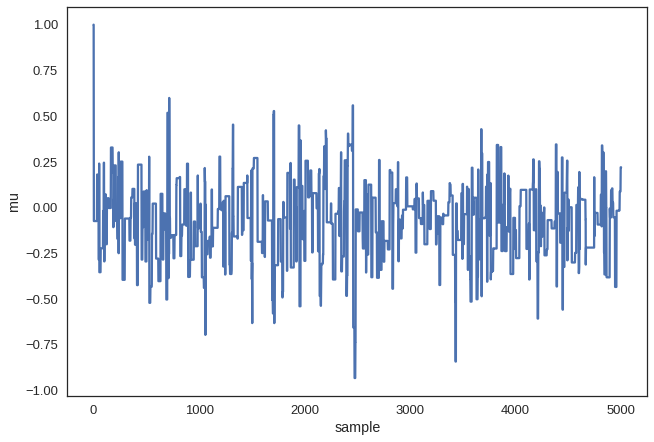

In [51]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

이렇게 해도 우리는 우리가 만들 사후모델에 샘플링은 가능하다 그러나 효율적이지는 못하다.

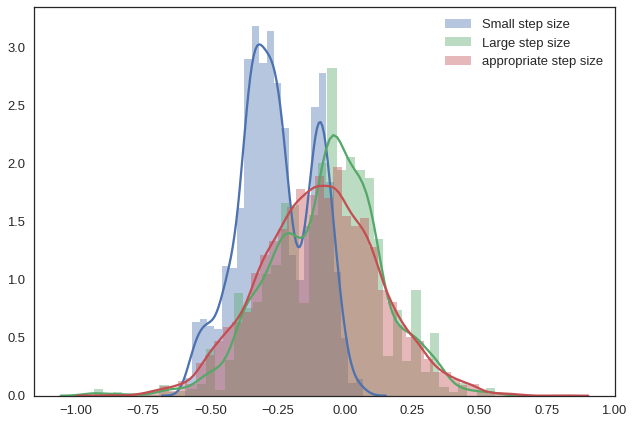

In [53]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
sns.distplot(posterior[1000:], label='appropriate step size');
_ = plt.legend();

결국에는 마찬가지로 사후분포와 같이 샘플링이 된다.
* 하지만 핵심은 우리가 원하는 샘플들간에 서로 독립이라는 조건이 만족하지 않게 된다.
* 그러므로 우리의 샘플러의 효율성을 평가하는 흔한 거리 지표로써 **autocorrelation**이 있다. 
* 즉 샘플 i-2 i-1 i 간의 상관관계를 보는 것이다.

In [0]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install patsy pandas

![대체 텍스트](https://preview.ibb.co/gT3SrT/autocorr.png)

Obviously we want to have a smart way of figuring out the right step width automatically.   

One common method is to keep adjusting the proposal width so that roughly 50% proposals are rejected.

# 더 복잡한 모델로 확장하기

우리는 $  \mu $ 가 아니느 $ \sigma $ 도 추가로 할 수 있다. 알고리즘적인 부분은 거의 동일하다.  
아니면 Binomial 과 같이 다른 분포로도 여전하 같은 알고리즘을 사용 할 수 있다.  

pymc3라는 패키지가 있는데 이것이 굉장히 좋다. 
Metropolis sampler 를 이용하면 자동적으로 proposal width 를 설정해 준다  그래서 동일한 결과를 낸다는 것을 알 수 있다.


Sequential sampling (2 chains in 1 job)
Metropolis: [mu]
100%|██████████| 15500/15500 [00:01<00:00, 13239.61it/s]
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The number of effective samples is smaller than 25% for some parameters.


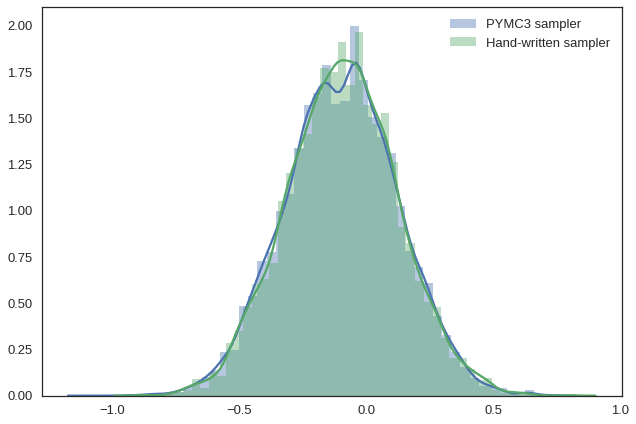

In [61]:
import pymc3 as pm

with pm.Model() :
    mu = pm.Normal("mu" ,0, 1)
    sigma=1.
    returns = pm.Normal("returns", mu=mu, sd=sigma , observed=data)
    
    step= pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]["mu"], label="PYMC3 sampler")
sns.distplot(posterior[500:], label="Hand-written sampler")
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1038d12cd0>,
      dtype=object)

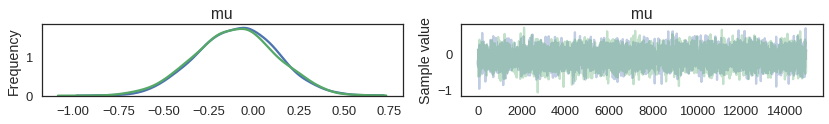

In [62]:
pm.traceplot(trace)

pymc 패키지를 이용하면 간단하면서도 더 잘된 구현이 가능하다.